# Phase 2: Feature Engineering Exploration

This notebook explores the feature engineering process for the Telco Customer Churn dataset, focusing on:

1. **Feature Transformations**: Analysis of engineered features (tenure buckets, service counts, revenue signals)
2. **Feature Distributions**: Understanding the distribution of transformed features
3. **Feature Importance**: Preliminary analysis of feature importance before modeling
4. **Feature Interactions**: Exploring relationships between engineered features and churn

## Objectives
- Understand the impact of feature engineering transformations
- Validate feature distributions and identify potential issues
- Generate insights to inform modeling strategies
- Document feature engineering decisions



In [1]:
import sys
from pathlib import Path

# Add project root to path - handle both notebook execution and script execution
current_dir = Path().resolve()
# Check if we're in notebooks/ directory or project root
if (current_dir / "src").exists():
    PROJECT_ROOT = current_dir
elif (current_dir.parent / "src").exists():
    PROJECT_ROOT = current_dir.parent
else:
    # Fallback: search up the tree
    for parent in current_dir.parents:
        if (parent / "src").exists():
            PROJECT_ROOT = parent
            break
    else:
        PROJECT_ROOT = current_dir

if str(PROJECT_ROOT) not in sys.path:
    sys.path.append(str(PROJECT_ROOT))

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Set style
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)

# Import project modules
from src.data.ingestion import clean_dataset, load_raw_dataset
from src.features.pipeline import apply_feature_pipeline, create_feature_pipeline
from src.features.transformers import (
    CustomerLifetimeValueTransformer,
    RevenueSignalTransformer,
    ServiceCountTransformer,
    TenureBucketTransformer,
)

print("Imports successful")

Imports successful


## 1. Load and Prepare Data

In [2]:
# Load latest processed snapshot or raw data
processed_dir = PROJECT_ROOT / "data" / "processed"

# Try to load latest processed snapshot
timestamp_dirs = (
    [d for d in processed_dir.iterdir() if d.is_dir()] if processed_dir.exists() else []
)

if timestamp_dirs:
    latest_dir = max(timestamp_dirs, key=lambda p: p.name)
    parquet_files = list(latest_dir.glob("*.parquet"))
    if parquet_files:
        df = pd.read_parquet(parquet_files[0])
        # Check if loaded data has required columns for feature engineering
        required_cols = ["tenure", "MonthlyCharges", "TotalCharges", "Churn"]
        if all(col in df.columns for col in required_cols):
            print(f"Loaded processed snapshot: {latest_dir.name}")
        else:
            # Fallback to raw data if required columns are missing
            print("Processed snapshot missing required columns, loading raw data...")
            raw_path = PROJECT_ROOT / "data" / "raw" / "telco_data_28_11_2025.csv"
            df = load_raw_dataset(raw_path)
            df = clean_dataset(df)
            print("Loaded and cleaned raw dataset")
    else:
        # Fallback to raw data
        raw_path = PROJECT_ROOT / "data" / "raw" / "telco_data_28_11_2025.csv"
        df = load_raw_dataset(raw_path)
        df = clean_dataset(df)
        print("Loaded and cleaned raw dataset")
else:
    # Load raw data
    raw_path = PROJECT_ROOT / "data" / "raw" / "telco_data_28_11_2025.csv"
    df = load_raw_dataset(raw_path)
    df = clean_dataset(df)
    print("Loaded and cleaned raw dataset")

print(f"\nDataset shape: {df.shape}")
print(f"Columns: {list(df.columns)}")
df.head()

Processed snapshot missing required columns, loading raw data...
Loaded and cleaned raw dataset

Dataset shape: (7043, 21)
Columns: ['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn']


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


## 2. Apply Feature Engineering Transformations

In [3]:
# Create feature pipeline
pipeline = create_feature_pipeline()

# Prepare dataframe for pipeline (drop customerID if present, keep all feature columns including Churn for fitting)
df_for_pipeline = df.drop(columns=["customerID"]) if "customerID" in df.columns else df.copy()

# Ensure tenure column exists
if "tenure" not in df_for_pipeline.columns:
    raise ValueError("'tenure' column is missing from the dataframe. Required columns: tenure")

# Fit pipeline on dataframe with Churn (pipeline will ignore Churn during fit)
pipeline.fit(df_for_pipeline)

# Apply transformations (this will drop Churn internally)
X_transformed, y = apply_feature_pipeline(df_for_pipeline, pipeline, target_column="Churn")

print(f"Original features: {df_for_pipeline.shape[1]}")
print(f"Transformed features: {X_transformed.shape[1]}")
print("\nFeature names (first 20):")
print(list(X_transformed.columns[:20]))

Original features: 20
Transformed features: 40

Feature names (first 20):
['num__SeniorCitizen', 'num__tenure', 'num__MonthlyCharges', 'num__TotalCharges', 'num__service_count', 'num__charges_ratio', 'num__avg_monthly_charge', 'num__charge_increase_flag', 'num__clv_approximation', 'cat__gender_Male', 'cat__Partner_Yes', 'cat__Dependents_Yes', 'cat__PhoneService_Yes', 'cat__MultipleLines_No phone service', 'cat__MultipleLines_Yes', 'cat__InternetService_Fiber optic', 'cat__InternetService_No', 'cat__OnlineSecurity_No internet service', 'cat__OnlineSecurity_Yes', 'cat__OnlineBackup_No internet service']


## 3. Analyze Engineered Features

Let's examine the custom transformers individually to understand their impact.


In [4]:
# Apply individual transformers to see intermediate results
df_with_features = df.copy()

# Tenure buckets
tenure_transformer = TenureBucketTransformer()
df_with_features = tenure_transformer.transform(df_with_features)

# Service count
service_transformer = ServiceCountTransformer()
df_with_features = service_transformer.transform(df_with_features)

# Revenue signals
revenue_transformer = RevenueSignalTransformer()
df_with_features = revenue_transformer.transform(df_with_features)

# CLV
clv_transformer = CustomerLifetimeValueTransformer()
df_with_features = clv_transformer.transform(df_with_features)

print("Applied all custom transformers")
print(f"\nNew columns added: {set(df_with_features.columns) - set(df.columns)}")
df_with_features[
    [
        "tenure_bucket",
        "service_count",
        "charges_ratio",
        "avg_monthly_charge",
        "charge_increase_flag",
        "clv_approximation",
    ]
].head(10)

Applied all custom transformers

New columns added: {'avg_monthly_charge', 'charge_increase_flag', 'tenure_bucket', 'service_count', 'clv_approximation', 'charges_ratio'}


,tenure_bucket,service_count,charges_ratio,avg_monthly_charge,charge_increase_flag,clv_approximation
0,0-12,1,1.000000,29.850000,0,388.05
1,25-36,2,0.030140,55.573529,1,2572.90
2,0-12,2,0.497920,54.075000,0,754.35
3,37-48,3,0.022980,40.905556,1,2348.35
4,0-12,0,0.466205,75.825000,0,1000.05
5,0-12,3,0.121450,102.562500,0,2016.30
6,13-24,2,0.045706,88.609091,1,3018.60
7,0-12,1,0.098543,30.190000,0,658.90
8,25-36,4,0.034405,108.787500,0,4303.65
9,61-72,2,0.016098,56.257258,0,4161.75


## 4. Feature Distributions and Churn Analysis


TENURE BUCKETS vs CHURN
Churn                 No        Yes
tenure_bucket                      
0-12           52.561757  47.438243
13-24          71.289062  28.710938
25-36          78.365385  21.634615
37-48          80.971129  19.028871
49-60          85.576923  14.423077
61-72          93.390192   6.609808




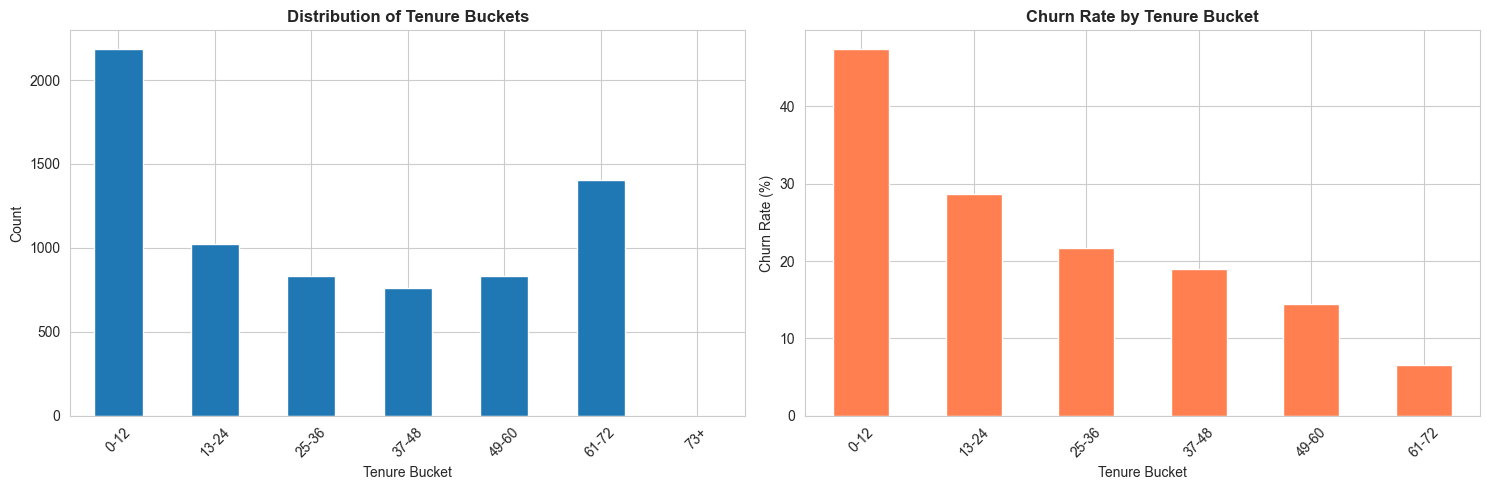

In [5]:
# Analyze tenure buckets vs churn
print("=" * 80)
print("TENURE BUCKETS vs CHURN")
print("=" * 80)
tenure_churn = (
    pd.crosstab(df_with_features["tenure_bucket"], df_with_features["Churn"], normalize="index")
    * 100
)
print(tenure_churn)
print("\n")

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Tenure bucket distribution
df_with_features["tenure_bucket"].value_counts().sort_index().plot(kind="bar", ax=axes[0])
axes[0].set_title("Distribution of Tenure Buckets", fontweight="bold")
axes[0].set_xlabel("Tenure Bucket")
axes[0].set_ylabel("Count")
axes[0].tick_params(axis="x", rotation=45)

# Churn rate by tenure bucket
tenure_churn["Yes"].plot(kind="bar", ax=axes[1], color="coral")
axes[1].set_title("Churn Rate by Tenure Bucket", fontweight="bold")
axes[1].set_xlabel("Tenure Bucket")
axes[1].set_ylabel("Churn Rate (%)")
axes[1].tick_params(axis="x", rotation=45)

plt.tight_layout()
plt.show()

SERVICE COUNT vs CHURN
Churn                 No        Yes
service_count                      
0              78.593961  21.406039
1              54.244306  45.755694
2              64.181994  35.818006
3              72.629696  27.370304
4              77.699531  22.300469
5              87.565674  12.434326
6              94.718310   5.281690




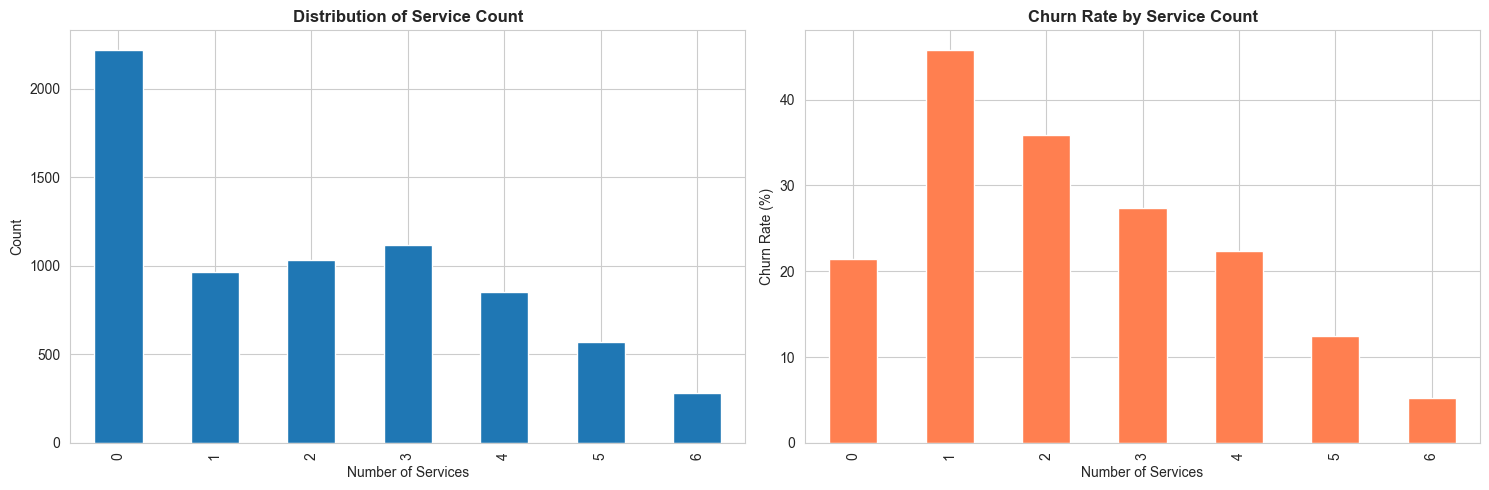

In [6]:
# Analyze service count vs churn
print("=" * 80)
print("SERVICE COUNT vs CHURN")
print("=" * 80)
service_churn = (
    pd.crosstab(df_with_features["service_count"], df_with_features["Churn"], normalize="index")
    * 100
)
print(service_churn)
print("\n")

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Service count distribution
df_with_features["service_count"].value_counts().sort_index().plot(kind="bar", ax=axes[0])
axes[0].set_title("Distribution of Service Count", fontweight="bold")
axes[0].set_xlabel("Number of Services")
axes[0].set_ylabel("Count")

# Churn rate by service count
service_churn["Yes"].plot(kind="bar", ax=axes[1], color="coral")
axes[1].set_title("Churn Rate by Service Count", fontweight="bold")
axes[1].set_xlabel("Number of Services")
axes[1].set_ylabel("Churn Rate (%)")

plt.tight_layout()
plt.show()

REVENUE SIGNALS vs CHURN

Charges Ratio Statistics:
        count      mean       std       min       25%       50%       75%  max
Churn                                                                         
No     5163.0  0.103644  0.215560  0.012604  0.016459  0.026553  0.066595  1.0
Yes    1869.0  0.306620  0.373642  0.013471  0.034358  0.102988  0.477054  1.0


CLV Approximation Statistics:
        count         mean          std     min       25%       50%      75%  \
Churn                                                                          
No     5174.0  3514.332702  2881.081514  236.40  1172.675  2420.525  5554.80   
Yes    1869.0  2451.835581  2135.582404  245.05   973.000  1621.400  3330.95   

            max  
Churn            
No     11522.45  
Yes    10571.60  


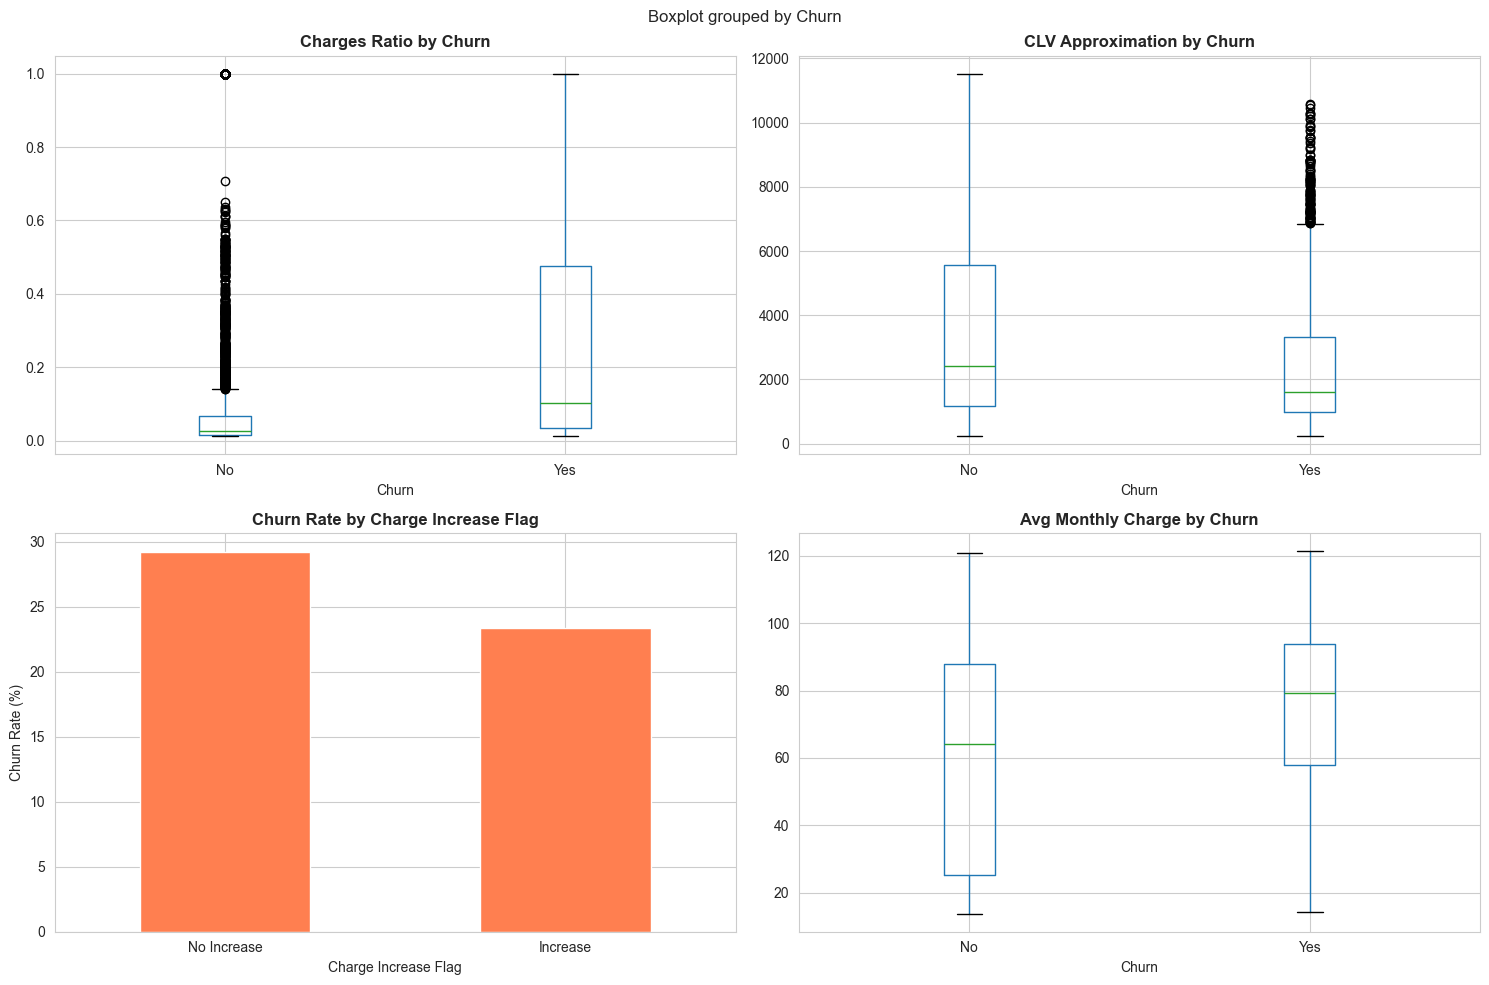

In [7]:
# Analyze revenue signals vs churn
print("=" * 80)
print("REVENUE SIGNALS vs CHURN")
print("=" * 80)

# Charges ratio
print("\nCharges Ratio Statistics:")
print(df_with_features.groupby("Churn")["charges_ratio"].describe())

# CLV approximation
print("\n\nCLV Approximation Statistics:")
print(df_with_features.groupby("Churn")["clv_approximation"].describe())

# Visualize
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Charges ratio distribution
df_with_features.boxplot(column="charges_ratio", by="Churn", ax=axes[0, 0])
axes[0, 0].set_title("Charges Ratio by Churn", fontweight="bold")
axes[0, 0].set_xlabel("Churn")

# CLV distribution
df_with_features.boxplot(column="clv_approximation", by="Churn", ax=axes[0, 1])
axes[0, 1].set_title("CLV Approximation by Churn", fontweight="bold")
axes[0, 1].set_xlabel("Churn")

# Charge increase flag
charge_increase_churn = (
    pd.crosstab(
        df_with_features["charge_increase_flag"], df_with_features["Churn"], normalize="index"
    )
    * 100
)
charge_increase_churn["Yes"].plot(kind="bar", ax=axes[1, 0], color="coral")
axes[1, 0].set_title("Churn Rate by Charge Increase Flag", fontweight="bold")
axes[1, 0].set_xlabel("Charge Increase Flag")
axes[1, 0].set_ylabel("Churn Rate (%)")
axes[1, 0].set_xticklabels(["No Increase", "Increase"], rotation=0)

# Average monthly charge
df_with_features.boxplot(column="avg_monthly_charge", by="Churn", ax=axes[1, 1])
axes[1, 1].set_title("Avg Monthly Charge by Churn", fontweight="bold")
axes[1, 1].set_xlabel("Churn")

plt.tight_layout()
plt.show()

## 5. Feature Correlation Analysis


FEATURE CORRELATIONS WITH CHURN
Churn_Numeric           1.000000
charges_ratio           0.318539
MonthlyCharges          0.193356
avg_monthly_charge      0.192033
SeniorCitizen           0.150889
charge_increase_flag   -0.066433
service_count          -0.087698
clv_approximation      -0.170999
TotalCharges           -0.199484
tenure                 -0.352229
Name: Churn_Numeric, dtype: float64


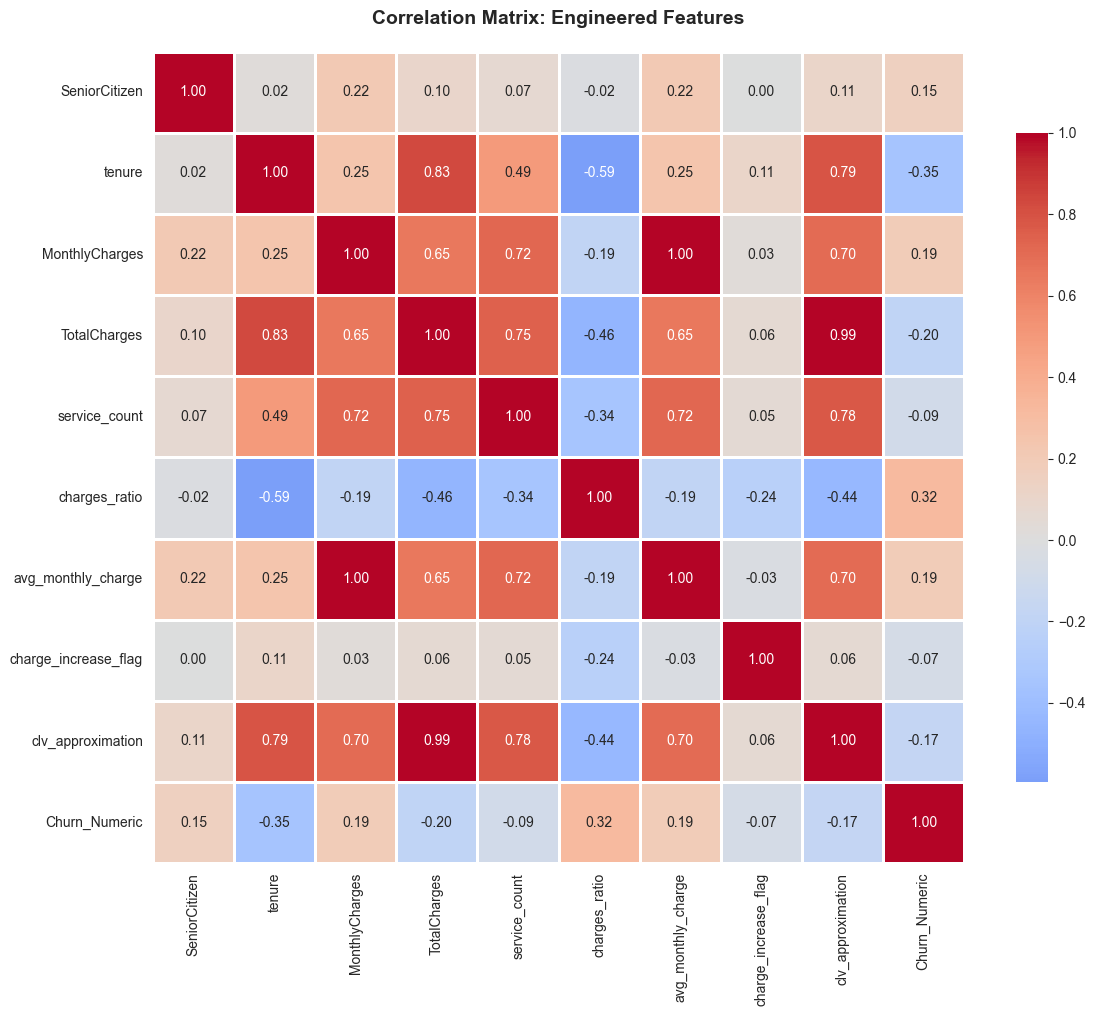

In [8]:
# Create correlation matrix with churn
numeric_features = [
    "SeniorCitizen",
    "tenure",
    "MonthlyCharges",
    "TotalCharges",
    "service_count",
    "charges_ratio",
    "avg_monthly_charge",
    "charge_increase_flag",
    "clv_approximation",
]
correlation_df = df_with_features[numeric_features].copy()
correlation_df["Churn_Numeric"] = df_with_features["Churn"].map({"Yes": 1, "No": 0})

correlation_matrix = correlation_df.corr()
churn_correlations = correlation_matrix["Churn_Numeric"].sort_values(ascending=False)

print("=" * 80)
print("FEATURE CORRELATIONS WITH CHURN")
print("=" * 80)
print(churn_correlations)

# Visualize
plt.figure(figsize=(12, 10))
sns.heatmap(
    correlation_matrix,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    center=0,
    square=True,
    linewidths=1,
    cbar_kws={"shrink": 0.8},
)
plt.title("Correlation Matrix: Engineered Features", fontweight="bold", fontsize=14, pad=20)
plt.tight_layout()
plt.show()

## 6. Feature Importance (Quick Baseline)

Run a quick baseline model to get preliminary feature importance.

### Key Findings:
1. **Tenure Buckets**: New customers (0-12 months) show highest churn rates
2. **Service Count**: Customers with fewer services are more likely to churn
3. **Revenue Signals**: Charge increases and higher charge ratios correlate with churn
4. **CLV**: Lower CLV approximations are associated with higher churn

### Feature Engineering Decisions:
- Tenure buckets provide clear segmentation
- Service count captures customer engagement
- Revenue signals identify pricing-related churn drivers
- CLV approximation helps prioritize retention efforts

### Next Steps:
- Proceed to Phase 3: Modeling with these engineered features
- Consider additional feature interactions if needed
- Validate feature importance through modeling


PRELIMINARY FEATURE IMPORTANCE (Random Forest)
             feature  importance
       charges_ratio    0.187509
      MonthlyCharges    0.179791
              tenure    0.159671
  avg_monthly_charge    0.153105
        TotalCharges    0.122129
   clv_approximation    0.122113
       service_count    0.043873
       SeniorCitizen    0.022578
charge_increase_flag    0.009231


<Figure size 1000x800 with 0 Axes>

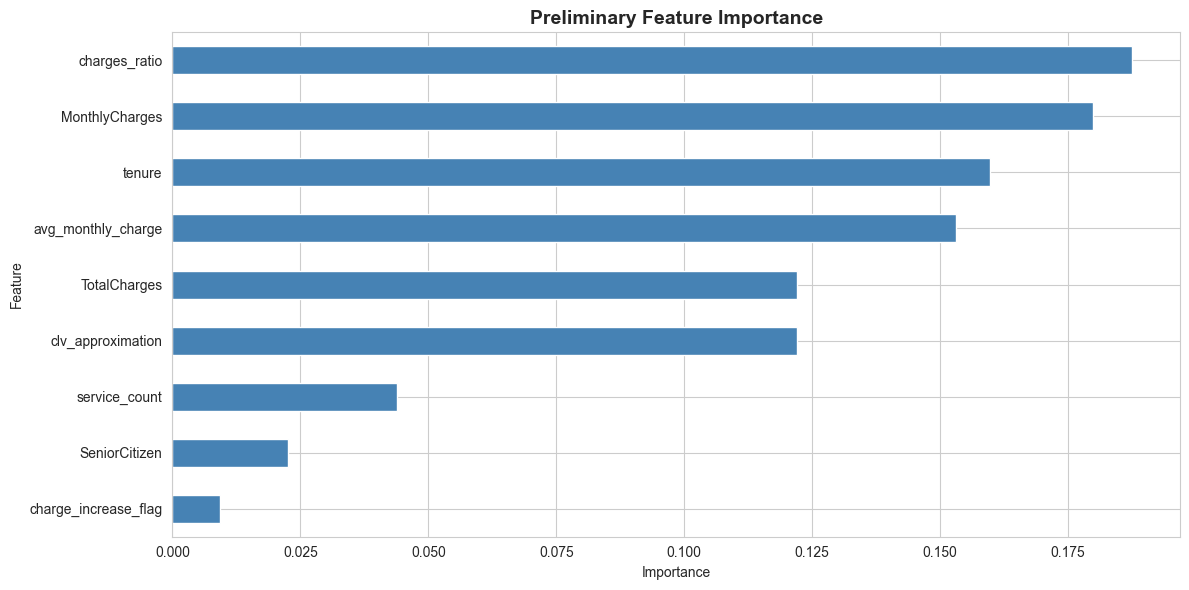


Note: This is a preliminary analysis. Full feature importance will be available after modeling.


In [9]:
# Quick feature importance using a simple model
from sklearn.ensemble import RandomForestClassifier

# Prepare data for quick model
X_quick = df_with_features[numeric_features].fillna(0)
y_quick = df_with_features["Churn"].map({"Yes": 1, "No": 0})

# Train a quick random forest for feature importance
rf_quick = RandomForestClassifier(n_estimators=100, random_state=42, max_depth=10)
rf_quick.fit(X_quick, y_quick)

# Get feature importance
feature_importance = pd.DataFrame(
    {"feature": numeric_features, "importance": rf_quick.feature_importances_}
).sort_values("importance", ascending=False)

print("=" * 80)
print("PRELIMINARY FEATURE IMPORTANCE (Random Forest)")
print("=" * 80)
print(feature_importance.to_string(index=False))

# Visualize
plt.figure(figsize=(10, 8))
feature_importance.plot(x="feature", y="importance", kind="barh", legend=False, color="steelblue")
plt.title("Preliminary Feature Importance", fontweight="bold", fontsize=14)
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

print(
    "\nNote: This is a preliminary analysis. Full feature importance will be available after modeling."
)